<a href="https://colab.research.google.com/github/sbesinski/kaggle_ML/blob/main/sleeping_time_sparkML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import kagglehub
import os

In [2]:
# Download latest version
path = kagglehub.dataset_download("govindaramsriram/sleep-time-prediction")

print("Path to dataset files:", path)
csv_path = os.path.join(path, "sleeptime_prediction_dataset.csv")
df = pd.read_csv(csv_path)
df

100%|██████████| 28.1k/28.1k [00:00<00:00, 20.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/govindaramsriram/sleep-time-prediction/versions/1


,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,1.12,0.52,3.29,7.89,216.08,0.75,3.45
1,2.85,0.49,4.22,5.03,206.18,0.67,4.88
2,2.20,1.81,4.04,9.23,28.73,0.35,3.61
3,1.80,0.50,1.62,7.68,276.77,1.21,4.94
4,0.47,0.54,1.60,4.94,170.54,0.95,5.50
...,...,...,...,...,...,...,...
1995,1.97,0.88,3.74,5.64,257.30,0.01,4.24
1996,2.87,0.67,3.01,5.26,269.25,1.75,5.89
1997,0.21,0.79,4.06,6.73,284.01,0.61,3.00
1998,0.17,1.06,2.94,9.45,119.25,1.88,3.53


In [3]:
from pyspark.sql.session import SparkSession

spark = SparkSession \
    .builder \
    .appName("ML") \
    .getOrCreate()

In [4]:
dataset = spark.createDataFrame(df)

In [5]:
dataset.printSchema()

root
 |-- WorkoutTime: double (nullable = true)
 |-- ReadingTime: double (nullable = true)
 |-- PhoneTime: double (nullable = true)
 |-- WorkHours: double (nullable = true)
 |-- CaffeineIntake: double (nullable = true)
 |-- RelaxationTime: double (nullable = true)
 |-- SleepTime: double (nullable = true)



In [6]:
dataset.show(10, truncate=True)

+-----------+-----------+---------+---------+--------------+--------------+---------+
|WorkoutTime|ReadingTime|PhoneTime|WorkHours|CaffeineIntake|RelaxationTime|SleepTime|
+-----------+-----------+---------+---------+--------------+--------------+---------+
|       1.12|       0.52|     3.29|     7.89|        216.08|          0.75|     3.45|
|       2.85|       0.49|     4.22|     5.03|        206.18|          0.67|     4.88|
|        2.2|       1.81|     4.04|     9.23|         28.73|          0.35|     3.61|
|        1.8|        0.5|     1.62|     7.68|        276.77|          1.21|     4.94|
|       0.47|       0.54|      1.6|     4.94|        170.54|          0.95|      5.5|
|       0.47|       1.52|     2.07|     9.77|        109.12|          1.73|     4.01|
|       0.17|        0.9|     2.44|     7.11|        226.96|          0.06|     3.62|
|        2.6|       1.55|     2.63|     4.44|         77.21|          1.29|     6.77|
|        1.8|       0.13|     3.72|     7.76|        2

In [7]:
dataset.describe().toPandas()

,summary,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,count,2000,2000,2000,2000,2000,2000,2000
1,mean,1.4959150000000003,0.9927849999999996,2.9851950000000005,6.926944999999995,147.49378000000007,1.0109550000000005,4.884374999999999
2,stddev,0.8766394989849535,0.5773026354880694,1.1517761310702055,1.723842897175398,84.65113905839392,0.5826194819136693,2.028892040210719
3,min,0.01,0.0,1.0,4.0,0.02,0.0,0.15
4,max,3.0,2.0,5.0,10.0,299.85,2.0,19.81


In [8]:
target_name = 'SleepTime'

In [9]:
feature_names = dataset.columns[:-1]
feature_names

['WorkoutTime',
 'ReadingTime',
 'PhoneTime',
 'WorkHours',
 'CaffeineIntake',
 'RelaxationTime']

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression

In [11]:
assembler = VectorAssembler(inputCols=feature_names, outputCol='features')
scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='features_scaled')
lin_reg = LinearRegression(featuresCol='features_scaled', labelCol=target_name)

pipeline = Pipeline(stages=[assembler, scaler, lin_reg])

In [12]:
train_set, test_set = dataset.randomSplit([0.85, 0.15], seed=42)

In [13]:
train_set.count(), test_set.count()

(1731, 269)

In [14]:
train_set.printSchema()

root
 |-- WorkoutTime: double (nullable = true)
 |-- ReadingTime: double (nullable = true)
 |-- PhoneTime: double (nullable = true)
 |-- WorkHours: double (nullable = true)
 |-- CaffeineIntake: double (nullable = true)
 |-- RelaxationTime: double (nullable = true)
 |-- SleepTime: double (nullable = true)



In [15]:
model = pipeline.fit(train_set)
predicted_train_set = model.transform(train_set)
predicted_test_set = model.transform(test_set)

In [16]:

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

In [17]:
regression_evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol=target_name)
regression_evaluator_rsme = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol=target_name)
regression_evaluator_r2 = RegressionEvaluator(metricName='r2', predictionCol='prediction', labelCol=target_name)
regression_evaluator_mae = RegressionEvaluator(metricName='mae', predictionCol='prediction', labelCol=target_name)

In [18]:
#regression_evaluator_rsme.evaluate(predicted_train_set)
print('RMSE:', regression_evaluator_rsme.evaluate(predicted_train_set))
#regression_evaluator_r2.evaluate(predicted_train_set)  # R-squared
print('R2:', regression_evaluator_r2.evaluate(predicted_train_set))
#regression_evaluator_mae.evaluate(predicted_train_set)  # Mean Absolute Error
print('MAE:', regression_evaluator_mae.evaluate(predicted_train_set))

RMSE: 1.7482151078227604
R2: 0.2588557051410404
MAE: 0.5680909054748086


In [19]:
#regression_evaluator_rsme.evaluate(predicted_test_set)
print('RMSE:', regression_evaluator_rsme.evaluate(predicted_test_set))
#regression_evaluator_r2.evaluate(predicted_test_set)
print('R2:', regression_evaluator_r2.evaluate(predicted_test_set))
#regression_evaluator_mae.evaluate(predicted_test_set)
print('MAE:', regression_evaluator_mae.evaluate(predicted_test_set))

RMSE: 1.7133848426800444
R2: 0.27577477992834454
MAE: 0.5572016893016882


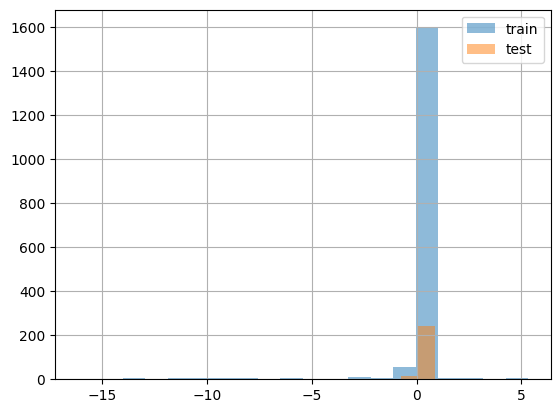

In [20]:
diffs_test = predicted_test_set.withColumn('diff',
                                           col('prediction') - col(target_name)).select('diff')
diffs_train = predicted_train_set.withColumn('diff',
                                           col('prediction') - col(target_name)).select('diff')
diffs_train.toPandas()['diff'].hist(bins=20, label='train', alpha=0.5)
diffs_test.toPandas()['diff'].hist(bins=20, label='test', alpha=0.5)
plt.legend()

In [21]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# lin_reg = LinearRegression(featuresCol='features_scaled', labelCol=target_name)

param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[2].regParam, [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]) \
    .addGrid(pipeline.getStages()[2].fitIntercept, [False, True])\
    .addGrid(pipeline.getStages()[2].elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=RegressionEvaluator(labelCol=target_name,
                                                  predictionCol='prediction'),
                    numFolds=5)

cv_model = cv.fit(train_set)

In [22]:
cv_model.transform(train_set).select('prediction').show(10)

+------------------+
|        prediction|
+------------------+
| 3.926767387356528|
| 4.576832362972226|
| 4.878828704487725|
| 5.470161979722212|
|  2.52759897162081|
| 5.424037348396492|
| 3.293400558196331|
| 3.003036390417031|
|2.5531237842663006|
| 5.269824283385049|
+------------------+
only showing top 10 rows



In [23]:
predicted_test_set = cv_model.transform(test_set)

In [24]:
regression_evaluator.evaluate(predicted_test_set)

1.714579220016286

In [25]:
diffs_test_cv = predicted_test_set.withColumn('diff', col('prediction') - col(target_name)).select('diff')
diffs_test_cv.show(5)

+-------------------+
|               diff|
+-------------------+
| 0.2220490816139593|
|0.46890946166443737|
| 0.0935418207940053|
|0.48377846405053804|
|  0.293024214839658|
+-------------------+
only showing top 5 rows



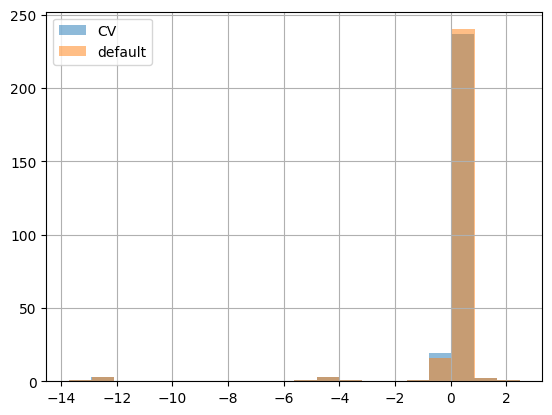

In [26]:
diffs_test_cv.toPandas()['diff'].hist(bins=20, label='CV', alpha=0.5)
diffs_test.toPandas()['diff'].hist(bins=20, label='default', alpha=0.5)
plt.legend()

In [27]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

pipeline = Pipeline(stages=[assembler, scaler, RandomForestRegressor(featuresCol='features_scaled', labelCol=target_name,  maxDepth=10, numTrees=20)])

In [28]:
train_set, test_set = dataset.randomSplit([0.85, 0.15], seed=42)

In [29]:
model = pipeline.fit(train_set)
predicted_train_set = model.transform(train_set)
predicted_test_set = model.transform(test_set)

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

regression_evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol=target_name)
regression_evaluator_rsme = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol=target_name)
regression_evaluator_r2 = RegressionEvaluator(metricName='r2', predictionCol='prediction', labelCol=target_name)
regression_evaluator_mae = RegressionEvaluator(metricName='mae', predictionCol='prediction', labelCol=target_name)

#regression_evaluator_rsme.evaluate(predicted_test_set)
print('RMSE:', regression_evaluator_rsme.evaluate(predicted_test_set))
#regression_evaluator_r2.evaluate(predicted_test_set)
print('R2:', regression_evaluator_r2.evaluate(predicted_test_set))
#regression_evaluator_mae.evaluate(predicted_test_set)
print('MAE:', regression_evaluator_mae.evaluate(predicted_test_set))


RMSE: 1.786798290269068
R2: 0.21238340224776409
MAE: 0.7268625715770283


In [31]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

pipeline = Pipeline(stages=[assembler, scaler, GBTRegressor(featuresCol='features_scaled', labelCol=target_name)])

model = pipeline.fit(train_set)
predicted_train_set = model.transform(train_set)
predicted_test_set = model.transform(test_set)

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

regression_evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol=target_name)
regression_evaluator_rsme = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol=target_name)
regression_evaluator_r2 = RegressionEvaluator(metricName='r2', predictionCol='prediction', labelCol=target_name)
regression_evaluator_mae = RegressionEvaluator(metricName='mae', predictionCol='prediction', labelCol=target_name)

#regression_evaluator_rsme.evaluate(predicted_test_set)
print('RMSE:', regression_evaluator_rsme.evaluate(predicted_test_set))
#regression_evaluator_r2.evaluate(predicted_test_set)
print('R2:', regression_evaluator_r2.evaluate(predicted_test_set))
#regression_evaluator_mae.evaluate(predicted_test_set)
print('MAE:', regression_evaluator_mae.evaluate(predicted_test_set))


RMSE: 1.8792171483584126
R2: 0.1288002606230514
MAE: 0.8615243296144209
